# Introduction

Do higher film budgets lead to more box office revenue? Let's find out if there's a relationship using the movie budgets and financial performance data that I've scraped from [the-numbers.com](https://www.the-numbers.com/movie/budgets) on **May 1st, 2018**. 

<img src=https://i.imgur.com/kq7hrEh.png>

# Import Statements

In [109]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.linear_model import LinearRegression

# Notebook Presentation

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Read the Data

In [3]:
data = pd.read_csv('cost_revenue_dirty.csv')

# Explore and Clean the Data

**Challenge**: Answer these questions about the dataset:
1. How many rows and columns does the dataset contain?
2. Are there any NaN values present?
3. Are there any duplicate rows?
4. What are the data types of the columns?

In [4]:
print(data.shape)
print(data.isna().values.any())
print(data.duplicated(keep=False).values.any())
print(type(data))
data.info()
data

(5391, 6)
False
False
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5391 entries, 0 to 5390
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Rank                   5391 non-null   int64 
 1   Release_Date           5391 non-null   object
 2   Movie_Title            5391 non-null   object
 3   USD_Production_Budget  5391 non-null   object
 4   USD_Worldwide_Gross    5391 non-null   object
 5   USD_Domestic_Gross     5391 non-null   object
dtypes: int64(1), object(5)
memory usage: 252.8+ KB


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
0,5293,8/2/1915,The Birth of a Nation,"$110,000","$11,000,000","$10,000,000"
1,5140,5/9/1916,Intolerance,"$385,907",$0,$0
2,5230,12/24/1916,"20,000 Leagues Under the Sea","$200,000","$8,000,000","$8,000,000"
3,5299,9/17/1920,Over the Hill to the Poorhouse,"$100,000","$3,000,000","$3,000,000"
4,5222,1/1/1925,The Big Parade,"$245,000","$22,000,000","$11,000,000"
...,...,...,...,...,...,...
5386,2950,10/8/2018,Meg,"$15,000,000",$0,$0
5387,126,12/18/2018,Aquaman,"$160,000,000",$0,$0
5388,96,12/31/2020,Singularity,"$175,000,000",$0,$0
5389,1119,12/31/2020,Hannibal the Conqueror,"$50,000,000",$0,$0


In [5]:
duplicated_rows = data[data.duplicated()]
len(duplicated_rows)

0

### Data Type Conversions

**Challenge**: Convert the `USD_Production_Budget`, `USD_Worldwide_Gross`, and `USD_Domestic_Gross` columns to a numeric format by removing `$` signs and `,`. 
<br>
<br>
Note that *domestic* in this context refers to the United States.

In [6]:
chars_to_remove = [',', '$']
columns_to_clean = ['USD_Production_Budget', 
                    'USD_Worldwide_Gross',
                    'USD_Domestic_Gross']
for col in columns_to_clean:
    for char in chars_to_remove:
        # Replace each character with an empty string
        data[col] = data[col].astype(str).str.replace(char, "")
    # Convert column to a numeric data type
    data[col] = pd.to_numeric(data[col])

C:\Users\Daniele\AppData\Local\Temp\ipykernel_17536\1274263461.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data[col] = data[col].astype(str).str.replace(char, "")


**Challenge**: Convert the `Release_Date` column to a Pandas Datetime type. 

In [7]:
data["Release_Date"] = pd.to_datetime(data["Release_Date"])

### Descriptive Statistics

**Challenge**: 

1. What is the average production budget of the films in the data set?
2. What is the average worldwide gross revenue of films?
3. What were the minimums for worldwide and domestic revenue?
4. Are the bottom 25% of films actually profitable or do they lose money?
5. What are the highest production budget and highest worldwide gross revenue of any film?
6. How much revenue did the lowest and highest budget films make?

In [8]:
data.describe()
data.sort_values("USD_Production_Budget")

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
2427,5391,2005-05-08,My Date With Drew,1100,181041,181041
5007,5390,2015-09-29,A Plague So Pleasant,1400,0,0
2462,5388,2005-07-13,Return to the Land of Wonders,5000,1338,1338
5006,5389,2015-09-29,Signed Sealed Delivered,5000,0,0
1209,5387,1999-02-04,Following,6000,240495,48482
...,...,...,...,...,...,...
4333,6,2013-02-07,The Lone Ranger,275000000,260002115,89302115
4925,4,2015-06-11,Spectre,300000000,879620923,200074175
2911,3,2007-05-24,Pirates of the Caribbean: At World’s End,300000000,963420425,309420425
5079,2,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,2058662225,936662225


# Investigating the Zero Revenue Films

**Challenge** How many films grossed $0 domestically (i.e., in the United States)? What were the highest budget films that grossed nothing?

In [9]:
zero_domestic = data[data.USD_Domestic_Gross == 0]
print(f'Number of films that grossed $0 domestically {len(zero_domestic)}')
zero_domestic.sort_values('USD_Production_Budget', ascending=False)

Number of films that grossed $0 domestically 512


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5388,96,2020-12-31,Singularity,175000000,0,0
5387,126,2018-12-18,Aquaman,160000000,0,0
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0
5385,366,2018-10-08,Amusement Park,100000000,0,0
5090,556,2015-12-31,"Don Gato, el inicio de la pandilla",80000000,4547660,0
...,...,...,...,...,...,...
4787,5371,2014-12-31,Stories of Our Lives,15000,0,0
3056,5374,2007-12-31,Tin Can Man,12000,0,0
4907,5381,2015-05-19,Family Motocross,10000,0,0
5006,5389,2015-09-29,Signed Sealed Delivered,5000,0,0


**Challenge**: How many films grossed $0 worldwide? What are the highest budget films that had no revenue internationally?

In [10]:
zero_worldwide = data[data.USD_Worldwide_Gross == 0]
print(f'Number of films that grossed $0 worldwide {len(zero_worldwide)}')
zero_worldwide.sort_values('USD_Production_Budget', ascending=False)

Number of films that grossed $0 worldwide 357


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5388,96,2020-12-31,Singularity,175000000,0,0
5387,126,2018-12-18,Aquaman,160000000,0,0
5384,321,2018-09-03,A Wrinkle in Time,103000000,0,0
5385,366,2018-10-08,Amusement Park,100000000,0,0
5058,880,2015-11-12,The Ridiculous 6,60000000,0,0
...,...,...,...,...,...,...
4787,5371,2014-12-31,Stories of Our Lives,15000,0,0
3056,5374,2007-12-31,Tin Can Man,12000,0,0
4907,5381,2015-05-19,Family Motocross,10000,0,0
5006,5389,2015-09-29,Signed Sealed Delivered,5000,0,0


### Filtering on Multiple Conditions

In [11]:
international_releases = data.loc[(data.USD_Domestic_Gross == 0)& 
                                  (data.USD_Worldwide_Gross != 0)]
international_releases

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
71,4310,1956-02-16,Carousel,3380000,3220,0
1579,5087,2001-02-11,Everything Put Together,500000,7890,0
1744,3695,2001-12-31,The Hole,7500000,10834406,0
2155,4236,2003-12-31,Nothing,4000000,63180,0
2203,2513,2004-03-31,The Touch,20000000,5918742,0
...,...,...,...,...,...,...
5340,1506,2017-04-14,Queen of the Desert,36000000,1480089,0
5348,2225,2017-05-05,Chāi dàn zhuānjiā,23000000,58807172,0
5360,4832,2017-07-03,Departure,1100000,27561,0
5372,1856,2017-08-25,Ballerina,30000000,48048527,0


**Challenge**: Use the [`.query()` function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.query.html) to accomplish the same thing. Create a subset for international releases that had some worldwide gross revenue, but made zero revenue in the United States. 

Hint: This time you'll have to use the `and` keyword.

In [12]:
internation_releas = data.query('USD_Worldwide_Gross != 0 and USD_Domestic_Gross == 0 ')
internation_releas

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
71,4310,1956-02-16,Carousel,3380000,3220,0
1579,5087,2001-02-11,Everything Put Together,500000,7890,0
1744,3695,2001-12-31,The Hole,7500000,10834406,0
2155,4236,2003-12-31,Nothing,4000000,63180,0
2203,2513,2004-03-31,The Touch,20000000,5918742,0
...,...,...,...,...,...,...
5340,1506,2017-04-14,Queen of the Desert,36000000,1480089,0
5348,2225,2017-05-05,Chāi dàn zhuānjiā,23000000,58807172,0
5360,4832,2017-07-03,Departure,1100000,27561,0
5372,1856,2017-08-25,Ballerina,30000000,48048527,0


### Unreleased Films

**Challenge**:
* Identify which films were not released yet as of the time of data collection (May 1st, 2018).
* How many films are included in the dataset that have not yet had a chance to be screened in the box office? 
* Create another DataFrame called data_clean that does not include these films. 

In [13]:
# Date of Data Collection
scrape_date = pd.Timestamp('2018-5-1')
data_clean = data[data["Release_Date"]<scrape_date]
data_clean.query('USD_Worldwide_Gross == 0').sort_values("USD_Production_Budget")

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
5007,5390,2015-09-29,A Plague So Pleasant,1400,0,0
5006,5389,2015-09-29,Signed Sealed Delivered,5000,0,0
4907,5381,2015-05-19,Family Motocross,10000,0,0
3056,5374,2007-12-31,Tin Can Man,12000,0,0
4787,5371,2014-12-31,Stories of Our Lives,15000,0,0
...,...,...,...,...,...,...
5045,1656,2015-10-30,Freaks of Nature,33000000,0,0
3300,1631,2008-12-31,Black Water Transit,35000000,0,0
5092,1435,2015-12-31,The Crow,40000000,0,0
5058,880,2015-11-12,The Ridiculous 6,60000000,0,0


In [14]:
data.sort_values("Release_Date")

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
0,5293,1915-08-02,The Birth of a Nation,110000,11000000,10000000
1,5140,1916-05-09,Intolerance,385907,0,0
2,5230,1916-12-24,"20,000 Leagues Under the Sea",200000,8000000,8000000
3,5299,1920-09-17,Over the Hill to the Poorhouse,100000,3000000,3000000
4,5222,1925-01-01,The Big Parade,245000,22000000,11000000
...,...,...,...,...,...,...
5385,366,2018-10-08,Amusement Park,100000000,0,0
5387,126,2018-12-18,Aquaman,160000000,0,0
5389,1119,2020-12-31,Hannibal the Conqueror,50000000,0,0
5388,96,2020-12-31,Singularity,175000000,0,0


### Films that Lost Money

**Challenge**: 
What is the percentage of films where the production costs exceeded the worldwide gross revenue? 

In [15]:
data_clean.query('USD_Production_Budget > USD_Worldwide_Gross')

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross
1,5140,1916-05-09,Intolerance,385907,0,0
6,4630,1927-12-08,Wings,2000000,0,0
8,4240,1930-01-01,Hell's Angels,4000000,0,0
15,4738,1936-05-02,Modern Times,1500000,165049,163245
17,4814,1936-10-20,"Charge of the Light Brigade, The",1200000,0,0
...,...,...,...,...,...,...
5371,4901,2017-07-28,An Inconvenient Sequel,1000000,130874,130874
5373,2161,2017-08-25,Tulip Fever,25000000,0,0
5374,4237,2017-08-25,Polina danser sa vie,4000000,36630,0
5381,94,2017-12-05,King Arthur: Legend of the Sword,175000000,140012608,39175066


# Seaborn for Data Viz: Bubble Charts

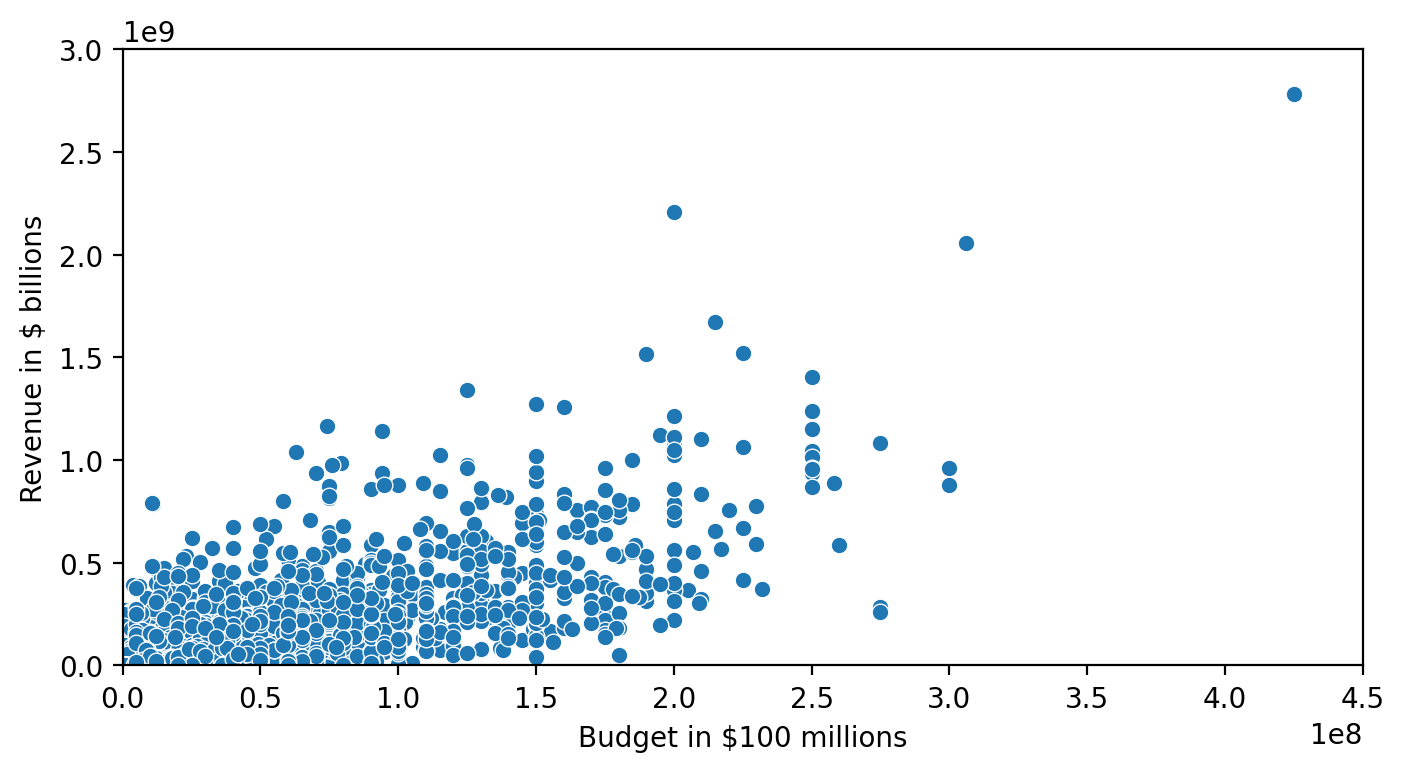

In [18]:
import seaborn as sns
plt.figure(figsize=(8,4), dpi=200)
ax = sns.scatterplot(data=data_clean,
                     x='USD_Production_Budget', 
                     y='USD_Worldwide_Gross')
ax.set(ylim=(0, 3000000000),
       xlim=(0, 450000000),
       ylabel='Revenue in $ billions',
       xlabel='Budget in $100 millions')
plt.show()

### Plotting Movie Releases over Time

**Challenge**: Try to create the following Bubble Chart:

<img src=https://i.imgur.com/8fUn9T6.png>



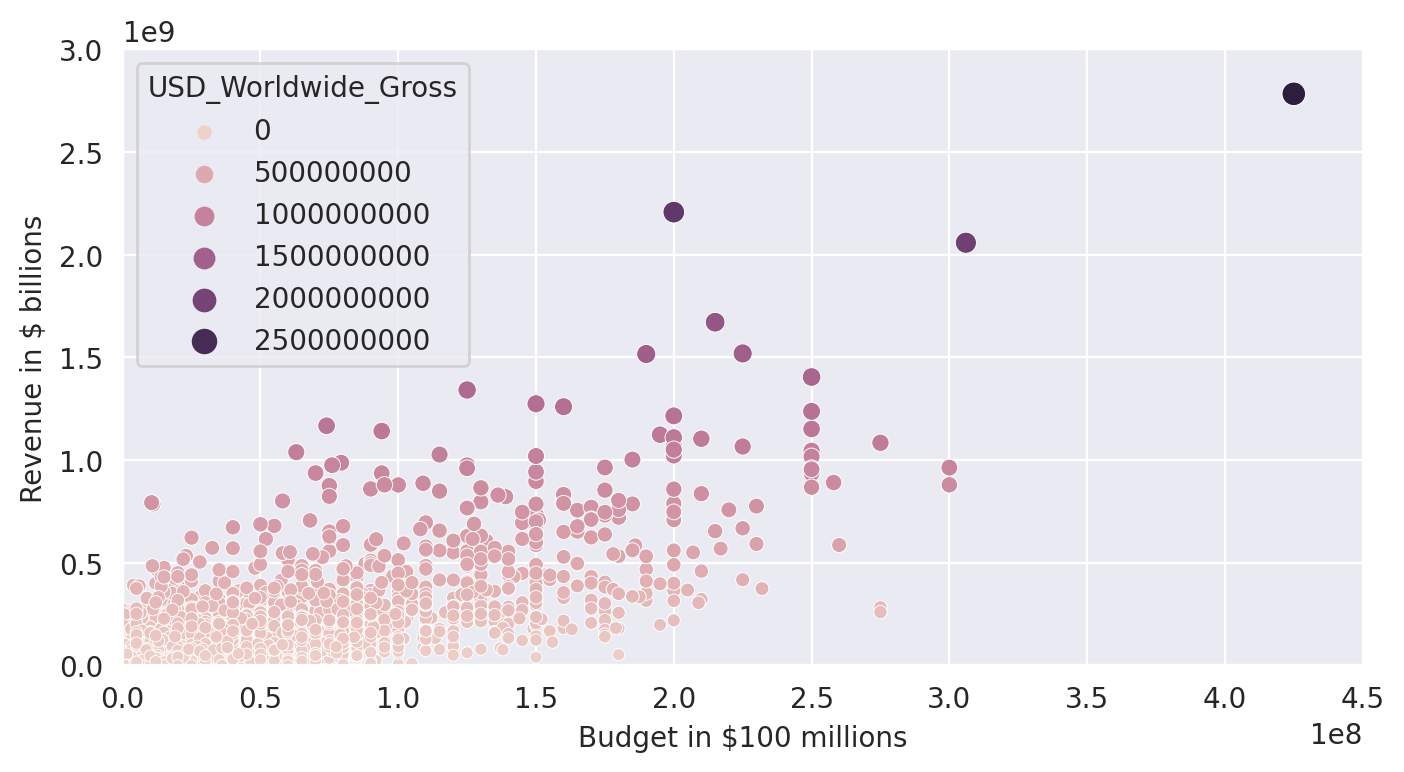

In [26]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style('darkgrid'):
  ax = sns.scatterplot(data=data_clean,
                       x='USD_Production_Budget', 
                       y='USD_Worldwide_Gross',
                       hue='USD_Worldwide_Gross',
                       size='USD_Worldwide_Gross')
  ax.set(ylim=(0, 3000000000),
        xlim=(0, 450000000),
        ylabel='Revenue in $ billions',
        xlabel='Budget in $100 millions')

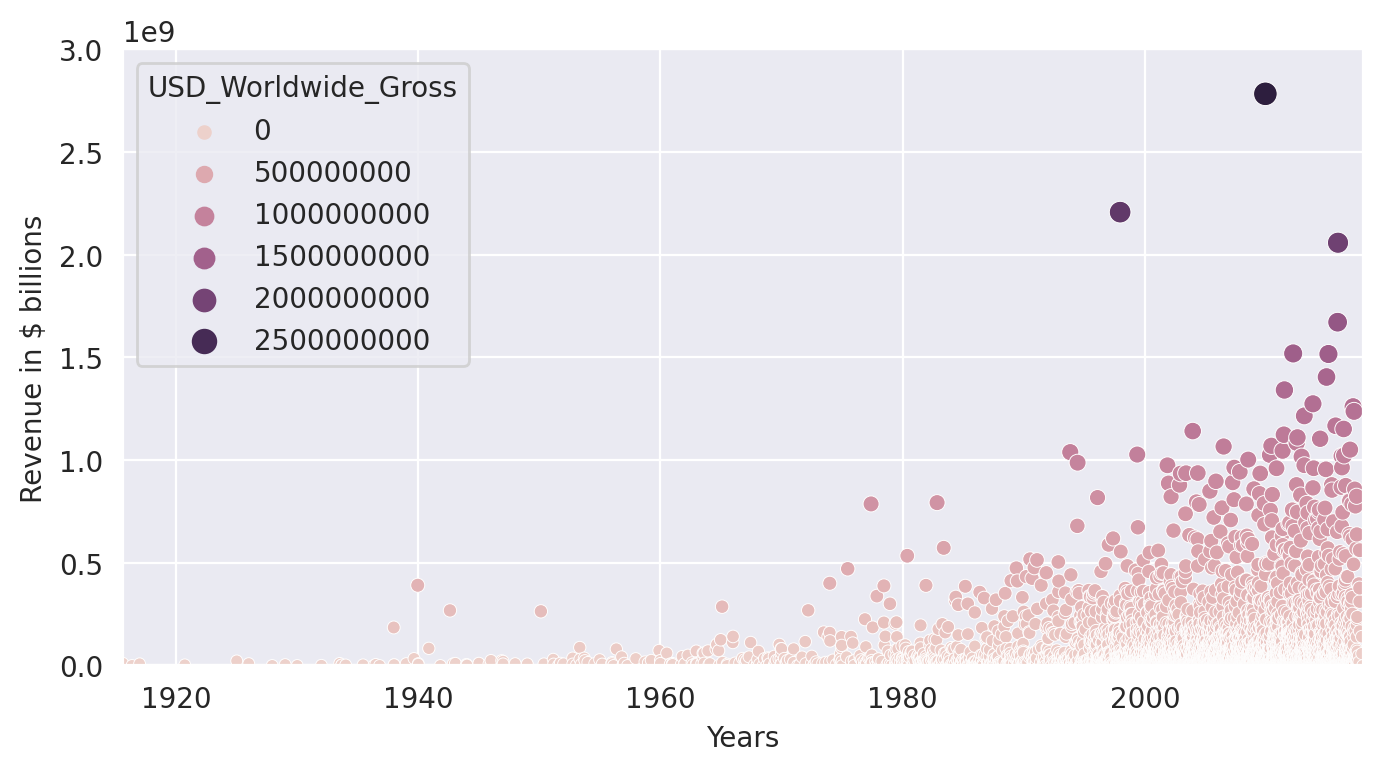

In [40]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style('darkgrid'):
  ax = sns.scatterplot(data=data_clean,
                       x='Release_Date', 
                       y='USD_Worldwide_Gross',
                       hue='USD_Worldwide_Gross',
                       size='USD_Worldwide_Gross')
  ax.set(ylim=(0, 3000000000),
        xlim=(data_clean.Release_Date.min(),data_clean.Release_Date.max()),
        ylabel='Revenue in $ billions',
        xlabel='Years')

# Converting Years to Decades Trick

**Challenge**: Create a column in `data_clean` that has the decade of the release. 

<img src=https://i.imgur.com/0VEfagw.png width=650> 

Here's how: 
1. Create a [`DatetimeIndex` object](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) from the Release_Date column. 
2. Grab all the years from the `DatetimeIndex` object using the `.year` property.
<img src=https://i.imgur.com/5m06Ach.png width=650>
3. Use floor division `//` to convert the year data to the decades of the films.
4. Add the decades as a `Decade` column to the `data_clean` DataFrame.

In [64]:
dt_index = pd.DatetimeIndex(data_clean["Release_Date"])
years = dt_index.year

0      1915-08-02
1      1916-05-09
2      1916-12-24
3      1920-09-17
4      1925-01-01
          ...    
5379   2017-10-02
5380   2017-10-03
5381   2017-12-05
5382   2017-12-05
5383   2017-12-31
Name: Release_Date, Length: 5384, dtype: datetime64[ns]

### Separate the "old" (before 1969) and "New" (1970s onwards) Films

**Challenge**: Create two new DataFrames: `old_films` and `new_films`
* `old_films` should include all the films before 1969 (up to and including 1969)
* `new_films` should include all the films from 1970 onwards
* How many films were released prior to 1970?
* What was the most expensive film made prior to 1970?

In [68]:
decade = years//10*10
data_clean['Decade'] = decade
data_pre = data_clean[data_clean['Decade'] < 1970]
data_post = data_clean[data_clean['Decade'] >= 1970]

C:\Users\Daniele\AppData\Local\Temp\ipykernel_17536\2147898647.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['Decade'] = decade


,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Worldwide_Gross,USD_Domestic_Gross,Decade
153,2159,1970-01-01,Waterloo,25000000,0,0,1970
154,2270,1970-01-01,Darling Lili,22000000,5000000,5000000,1970
155,3136,1970-01-01,Patton,12000000,62500000,62500000,1970
156,3277,1970-01-01,The Molly Maguires,11000000,2200000,2200000,1970
157,4265,1970-01-01,M*A*S*H,3500000,81600000,81600000,1970
...,...,...,...,...,...,...,...
5379,1295,2017-10-02,John Wick: Chapter Two,40000000,166893990,92029184,2010
5380,70,2017-10-03,Kong: Skull Island,185000000,561137727,168052812,2010
5381,94,2017-12-05,King Arthur: Legend of the Sword,175000000,140012608,39175066,2010
5382,1254,2017-12-05,Snatched,42000000,57850343,45850343,2010


In [73]:
print(data_pre.shape[0])
print(data_pre.max())


153
Rank                                    5299
Release_Date             1969-12-19 00:00:00
Movie_Title              You Only Live Twice
USD_Production_Budget               42000000
USD_Worldwide_Gross                390525192
USD_Domestic_Gross                 198680470
Decade                                  1960
dtype: object


# Seaborn Regression Plots

<Axes: xlabel='USD_Production_Budget', ylabel='USD_Worldwide_Gross'>

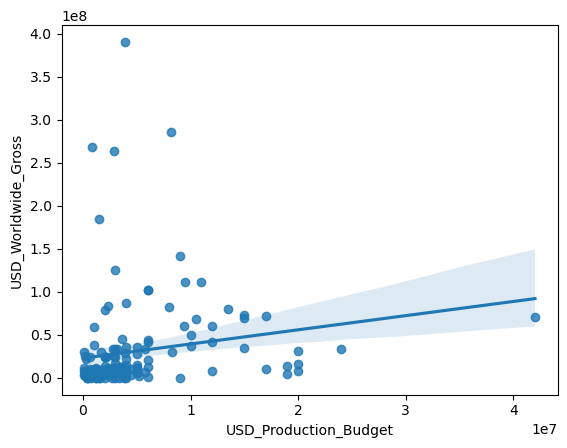

In [75]:
sns.regplot(data=data_pre, 
            x='USD_Production_Budget',
            y='USD_Worldwide_Gross')

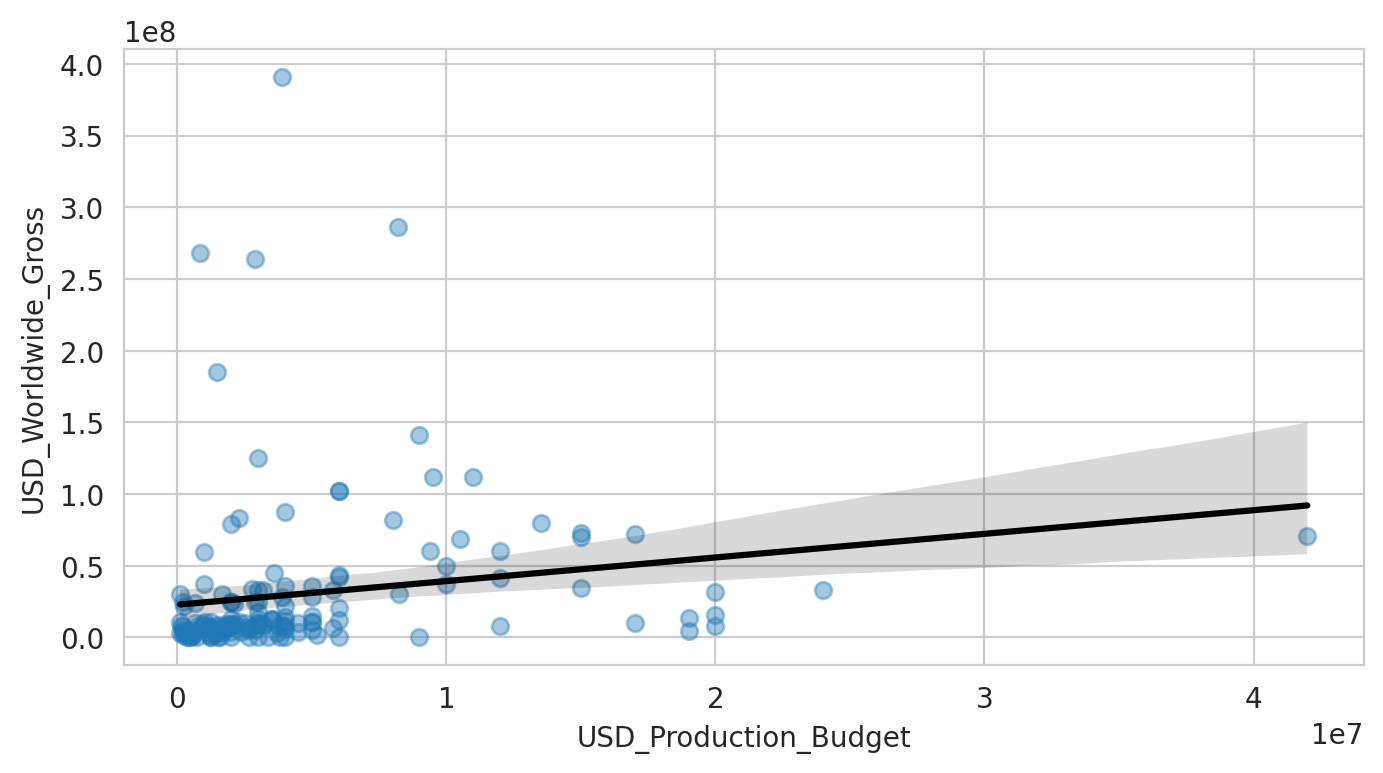

In [77]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style("whitegrid"):
  sns.regplot(data=data_pre, 
            x='USD_Production_Budget', 
            y='USD_Worldwide_Gross',
            scatter_kws = {'alpha': 0.4},
            line_kws = {'color': 'black'})

**Challenge**: Use Seaborn's `.regplot()` to show the scatter plot and linear regression line against the `new_films`. 
<br>
<br>
Style the chart

* Put the chart on a `'darkgrid'`.
* Set limits on the axes so that they don't show negative values.
* Label the axes on the plot "Revenue in \$ billions" and "Budget in \$ millions".
* Provide HEX colour codes for the plot and the regression line. Make the dots dark blue (#2f4b7c) and the line orange (#ff7c43).

Interpret the chart

* Do our data points for the new films align better or worse with the linear regression than for our older films?
* Roughly how much would a film with a budget of $150 million make according to the regression line?

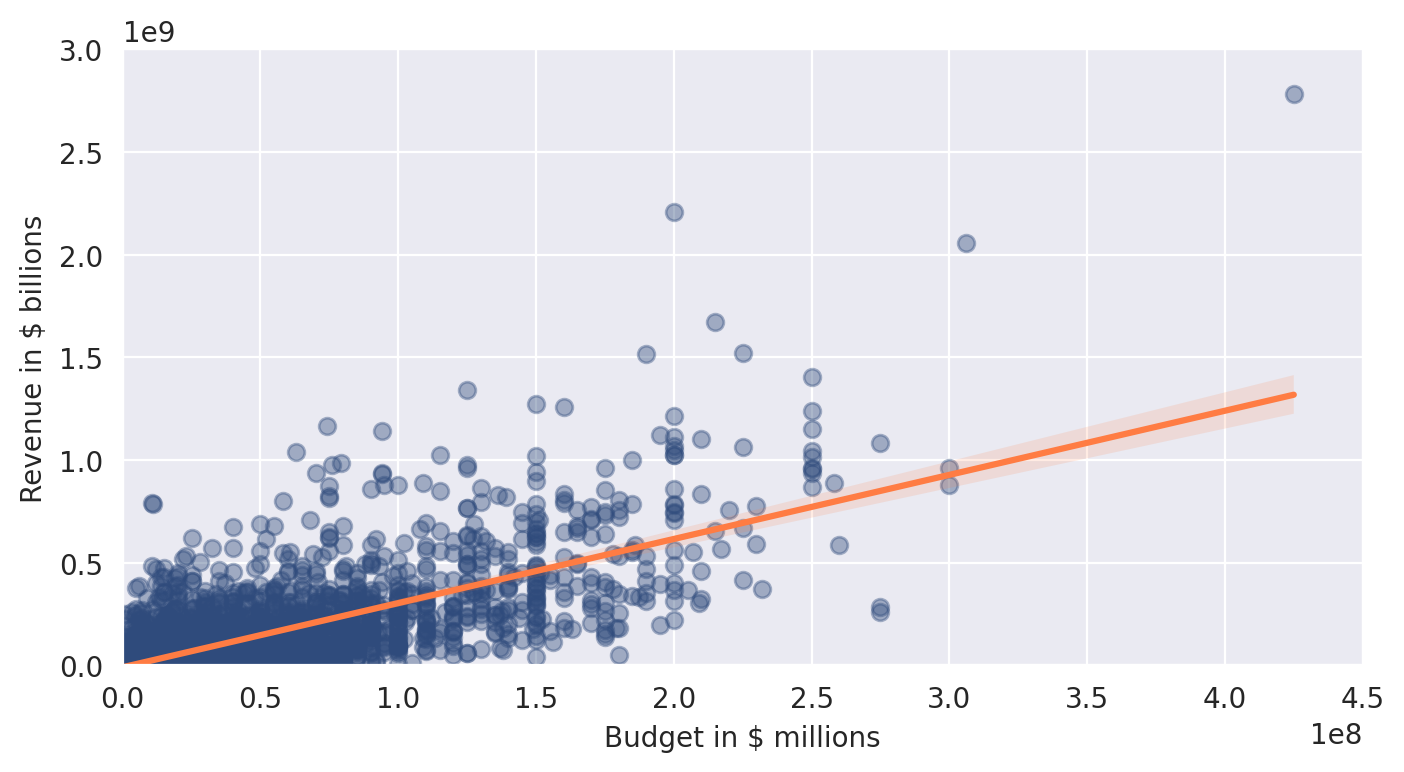

In [107]:
plt.figure(figsize=(8,4), dpi=200)

with sns.axes_style("darkgrid"):
    ax = sns.regplot(data=data_post, 
            x='USD_Production_Budget', 
            y='USD_Worldwide_Gross',
            scatter_kws = {'alpha': 0.4, 'color' : '#2f4b7c'},
            line_kws = {'color': '#ff7c43'})
    ax.set(ylim=(0, 3000000000),
         xlim=(0, 450000000),
         xlabel="Budget in $ millions",
         ylabel="Revenue in $ billions"
  )
    
    

# Run Your Own Regression with scikit-learn

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

In [113]:
regression = LinearRegression()
# Explanatory Variable(s) or Feature(s)
X = pd.DataFrame(data_post, columns=['USD_Production_Budget'])
# Response Variable or Target
y = pd.DataFrame(data_post, columns=['USD_Worldwide_Gross']) 
regression.fit(X, y)

LinearRegression()

**Challenge**: Run a linear regression for the `old_films`. Calculate the intercept, slope and r-squared. How much of the variance in movie revenue does the linear model explain in this case?

In [117]:
print(regression.intercept_)
regression.coef_

[-8650768.00661024]


array([[3.12259592]])

In [116]:
# R-squared
regression.score(X, y)

0.5577032617720403

# Use Your Model to Make a Prediction

We just estimated the slope and intercept! Remember that our Linear Model has the following form:

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

**Challenge**:  How much global revenue does our model estimate for a film with a budget of $350 million? 

In [118]:
regression = LinearRegression()
# Explanatory Variable(s) or Feature(s)
X = pd.DataFrame(data_pre, columns=['USD_Production_Budget'])
# Response Variable or Target
y = pd.DataFrame(data_pre, columns=['USD_Worldwide_Gross']) 
regression.fit(X, y)

LinearRegression()

In [121]:
print(regression.intercept_)
print(regression.coef_)
# R-squared
regression.score(X, y)

[22821538.63508038]
[[1.64771314]]


0.02937258620576877